# Bing Pilot Notebook
Purpose is to use Selenium to query names to test for ads via Bing.<br>
By: Jonathan Lo<br>
Date: 11/2/23

## Overhead

In [123]:
# Imports
import re
import logging
import os

import pandas as pd
import numpy as np

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
from collections import defaultdict
from tqdm.notebook import tqdm

from util import *
from matplotlib import pyplot as plt
import scipy.stats as stats

In [96]:
# Setup logger
if not os.path.exists('../logs/'):
    os.mkdir('../logs/')
if not os.path.exists('../logs/bing-pilot.log'):
    open('../logs/bing-pilot.log', 'a').close()

logging.basicConfig(
    filename='../logs/bing-pilot.log',
    filemode='w',
    format='%(asctime)s %(message)s',
    datefmt='%m/%d/%Y %I:%M:%S %p',
    level=logging.DEBUG
)

In [97]:
# Setup Webdriver Options
options = Options()

options.add_argument("--disable-notifications")
options.add_argument("--incognito")
options.add_experimental_option("prefs", {"plugins.plugins_list": [{"enabled": False, "name": "Chrome PDF Viewer"}]})
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option('useAutomationExtension', False)
options.add_argument("--start-maximized")
options.add_argument("--disable-blink-features")
options.add_argument('--disable-extensions')
options.add_argument("--no-sandbox")

options.binary_location = "/usr/local/bin/webdriver"

In [98]:
# Setup Selenium
print("Internet connected: ", internet())
driver = webdriver.Chrome(options=options)

Internet connected:  True


## Collection

### Generating Names

In [99]:
# Init names
path = "./../data/pilot-names.json"
white_female_names = generate_names(path, 'white', 'female')
white_male_names = generate_names(path, 'white', 'male')
black_female_names = generate_names(path, 'black', 'female')
black_male_names = generate_names(path, 'black', 'male')
all_names = {
    "wf": white_female_names,
    "wm": white_male_names,
    "bf": black_female_names,
    "bm": black_male_names
}

In [100]:
len(all_names['wm'])

176

### Querying

In [101]:
def parse_bing_ads(raw_html, query):
    """ Parses the doman.TLD and the title, URL from the HTML
    """
    compiled = defaultdict(list)
    pattern = r'(?:http[s]?://)?(?:www\.)?([\w-]+\.[\w-]+)' # Matches the domain and TLD of a URL
    ads = BeautifulSoup(raw_html).select('.sb_add')
    for ad in ads:
        try:
            title = ad.select_one('h2').text
            link = ad.select_one('.b_adurl').text
            match = re.search(pattern, link)
            domain = match.group(1) if match else 'ERROR'
            compiled[domain].append((title, link))
        except Exception as e:
            logging.debug(f'Failed to parse ad HTML on query: {query}')
    return compiled

In [102]:
us_states = [
    "California",
    "Wyoming",
    "Massachusetts",
    "Texas"
]

In [103]:
name = 'Allison Smith'
name.split()

['Allison', 'Smith']

In [104]:
# Querying all names and obtaining the ads on the page (est. 4min)
all_ads = [['Name', 'Group', 'Ad Domain', 'Ad Title', 'Ad Link']]
for group, names in tqdm(all_names.items()):
    for name in tqdm(names):
        name = name.split()
        #for state in us_states:
        for initial in ['d', 'r', 'j', 'm']:
            for i in range(4):
                query = f"{name[0]} {initial} {name[1]} public records"
                raw_html = bing_search(query, driver)
                parsed = parse_bing_ads(raw_html, query)
                for domain, ad_items in parsed.items():
                    for ad_opts in ad_items:
                        all_ads.append([name, group, domain, ad_opts[0], ad_opts[1]])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

In [106]:
len(all_ads)

48626

## Analysis

### Labelling

In [125]:
# Init DF
df = pd.DataFrame(all_ads[1:], columns=all_ads[0])

In [158]:
# Label
mapping = {'wf': ('White', 'Female'), 'wm': ('White', 'Male'), 'bf': ('Black', 'Female'), 'bm': ('Black', 'Male')}
df['Race'] = df['Group'].map(mapping).str[0]
df['Sex'] = df['Group'].map(mapping).str[1]
df['Criminal Ad'] = df['Ad Title'].str.lower().str.contains('criminal|jail|arrest')

In [159]:
# Showing dataframe
df.head()

,Name,Group,Ad Domain,Ad Title,Ad Link,Race,Sex,Criminal Ad
0,"[Allison, Smith]",wf,spokeo.com,Search Public Records Online | Enter Any Name ...,https://www.spokeo.com,White,Female,False
1,"[Allison, Smith]",wf,spokeo.com,Search Public Records Online | Enter Any Name ...,https://www.spokeo.com,White,Female,False
2,"[Allison, Smith]",wf,publicrecords.info,Search Public Records | Find Someone Online | ...,https://www.publicrecords.info/Birth/Records,White,Female,False
3,"[Allison, Smith]",wf,publicrecords.info,Search Public Records | Find Someone Online | ...,https://www.publicrecords.info/Birth/Records,White,Female,False
4,"[Allison, Smith]",wf,tracking.instantcheckmate,Search Public Records 2023 | Just Type in a Na...,https://tracking.instantcheckmate.com/People/S...,White,Female,False


In [160]:
df['Criminal Ad'].value_counts()

Criminal Ad
False    43795
True      4830
Name: count, dtype: int64

### Breakdown

In [162]:
# Show breakdowns
counts_r = df.groupby(['Race'])['Name'].count()
counts_rs = df.groupby(['Race', 'Sex'])['Name'].count()
display(counts_r.to_frame())
display(counts_rs.to_frame())

,Name
Race,
Black,24989
White,23636


Name
Race  Sex          
Black Female  12495
      Male    12494
White Female  11737
      Male    11899

In [163]:
breakdown_regular = df.groupby('Group')['Criminal Ad'].count()
only_criminal = df[df['Criminal Ad']]
breakdown_criminal = only_criminal.groupby('Group')['Criminal Ad'].count()
#prep for racial + gender group statistical test

cont_table = [[breakdown_criminal['bf'], breakdown_regular['bf']], 
              [breakdown_criminal['bm'], breakdown_regular['bm']], 
              [breakdown_criminal['wf'], breakdown_regular['wf']], 
              [breakdown_criminal['wm'], breakdown_regular['wm']]]
cont_table

[[1301, 12495], [1230, 12494], [1043, 11737], [1256, 11899]]

In [164]:
#prep for racial group statistical test

obs = [df.groupby('Race')['Criminal Ad'].count()['Black'], df.groupby('Race')['Criminal Ad'].count()['White']]
successes = [only_criminal.groupby('Race')['Criminal Ad'].count()['Black'], only_criminal.groupby('Race')['Criminal Ad'].count()['White']]

In [165]:
#prep for gender group statistical test

obs_gender = [df.groupby('Sex')['Criminal Ad'].count()['Female'], df.groupby('Sex')['Criminal Ad'].count()['Male']]
successes_gender = [only_criminal.groupby('Sex')['Criminal Ad'].count()['Female'], only_criminal.groupby('Sex')['Criminal Ad'].count()['Male']]

Grouped by race and gender:
With a p-value of 0.0, we reject the null hypothesis. There is statistically significant difference between the proportions.


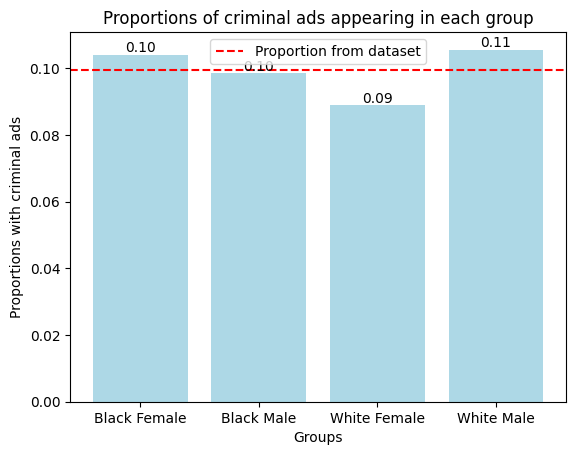

In [166]:
#Chi-Square Test
#To compare the rates of criminal ads and regular ads shown to each gender + racial group.


#Null Hypothesis: All four proportions come from the same distribution (i.e. they are equal)
#Alternative Hypothesis: All four proportions are not the same.


chi2, p, dof, expected = stats.chi2_contingency(cont_table)
if p < 0.05:
    print(f"Grouped by race and gender:\nWith a p-value of {round(p, 3)}, we reject the null hypothesis. There is statistically significant difference between the proportions.")
else:
    print(f"Grouped by race and gender:\nWith a p-value of {round(p, 3)}, we fail to reject the null hypothesis. There is no statistically significant difference in the proportions.")
proportions = [(breakdown_criminal['bf'] / breakdown_regular['bf']), (breakdown_criminal['bm'] / breakdown_regular['bm']), (breakdown_criminal['wf'] / breakdown_regular['wf']), (breakdown_criminal['wm']/breakdown_regular['wm'])]  
group_labels = ['Black Female', 'Black Male', 'White Female', 'White Male']
overall_prop = len(only_criminal) / len(df)
plt.bar(group_labels, proportions, color='lightblue')
plt.axhline(y=overall_prop, color='red', linestyle='--', label='Proportion from dataset')
for i in range(len(group_labels)):
    plt.text(i, proportions[i], f'{proportions[i]:.4f}', ha='center', va='bottom')
plt.xlabel('Groups')
plt.ylabel('Proportions with criminal ads')
plt.title('Proportions of criminal ads appearing in each group')
plt.legend(loc='lower left')
plt.show()

In [139]:
def two_prop_z_test(s, o):
    p1 = s[0] / o[0]
    p2 = s[1] / o[1]
    pooled_p = np.sum(s) / np.sum(o)
    se = np.sqrt(pooled_p * (1 - pooled_p) * ((1 / o[0]) + (1 / o[1])))
    z = (p1 - p2) / se
    p_val = 2 * (1 - stats.norm.cdf(np.abs(z)))
    return p_val

Grouped by race:
With a p-value of 0.139, we fail to reject the null hypothesis. There is no statistically significant difference between the two proportions.


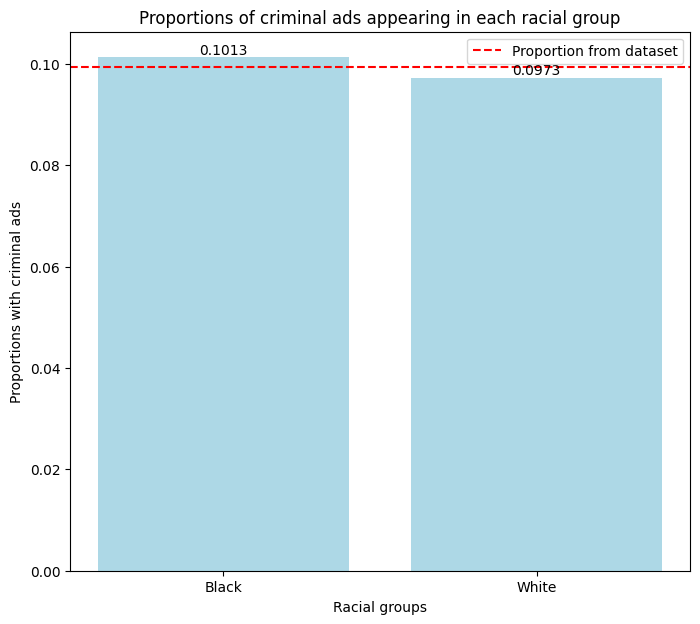

In [185]:
#Two-Proportion Z Test
#To compare just racial groups criminal ads vs. regular ads


#Null Hypothesis: The two proportions are the same
#Alternative Hypothesis: The two proportions are different


p_val = two_prop_z_test(successes, obs)
if p_val < 0.05:
    print(f"Grouped by race:\nWith a p-value of {round(p_val, 3)}, we reject the null hypothesis. There is a statistically significant difference between the two proportions.")
else:
    print(f"Grouped by race:\nWith a p-value of {round(p_val, 3)}, we fail to reject the null hypothesis. There is no statistically significant difference between the two proportions.")
    
black_prop = successes[0] / obs[0]
white_prop = successes[1] / obs[1]
racial_props = [black_prop, white_prop]
racial_groups = ['Black', 'White']
fig = plt.figure(figsize=(8,7))

plt.bar(racial_groups, racial_props, color='lightblue')
plt.axhline(y=overall_prop, color='red', linestyle='--', label='Proportion from dataset')
for i in range(len(racial_groups)):
    plt.text(i, racial_props[i], f'{racial_props[i]:.4f}', ha='center', va='bottom')
plt.xlabel('Racial groups')
plt.ylabel('Proportions with criminal ads')
plt.title('Proportions of criminal ads appearing in each racial group')
plt.legend(loc='lower left')
plt.show()

Grouped by gender:
With a p-value of 0.056, we fail to reject the null hypothesis. There is no statistically significant difference between the two proportions.


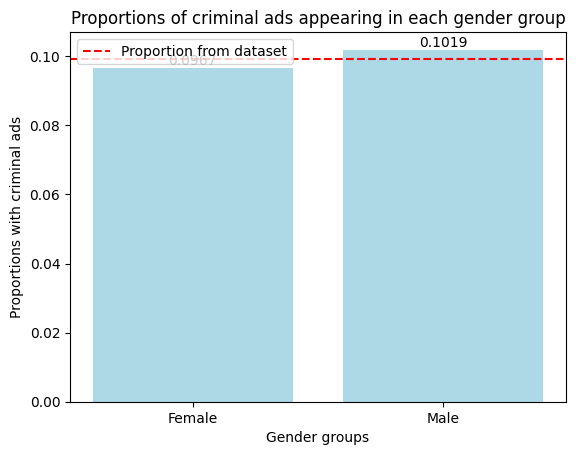

In [180]:
#Two-Proportion Z Test
#To compare just gender groups criminal ads vs. regular ads


#Null Hypothesis: The two proportions are the same
#Alternative Hypothesis: The two proportions are different


p_val2 = two_prop_z_test(successes_gender, obs_gender)
if p_val2 < 0.05:
    print(f"Grouped by gender:\nWith a p-value of {round(p_val2, 3)}, we reject the null hypothesis. There is a statistically significant difference between the two proportions.")
else:
    print(f"Grouped by gender:\nWith a p-value of {round(p_val2, 3)}, we fail to reject the null hypothesis. There is no statistically significant difference between the two proportions.")
female_prop = successes_gender[0] / obs_gender[0]
male_prop = successes_gender[1] / obs_gender[1]
gender_props = [female_prop, male_prop]
gender_groups = ['Female', 'Male']

plt.bar(gender_groups, gender_props, color='lightblue')
plt.axhline(y=overall_prop, color='red', linestyle='--', label='Proportion from dataset')
for i in range(len(gender_groups)):
    plt.text(i, gender_props[i], f'{gender_props[i]:.4f}', ha='center', va='bottom')
plt.xlabel('Gender groups')
plt.ylabel('Proportions with criminal ads')
plt.title('Proportions of criminal ads appearing in each gender group')
plt.legend(loc='lower left')
plt.show()

Ad Domain: spokeo.com
13183 ads from this domain


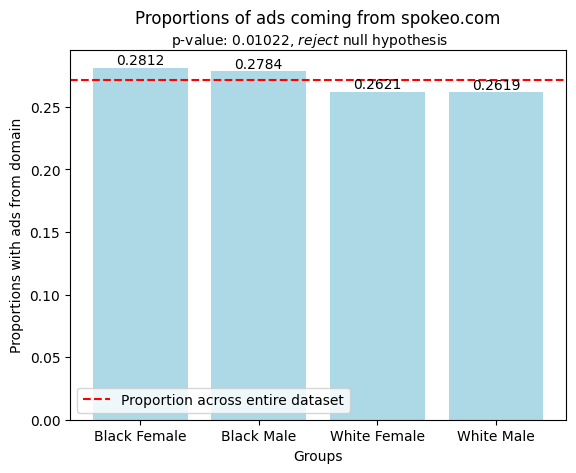

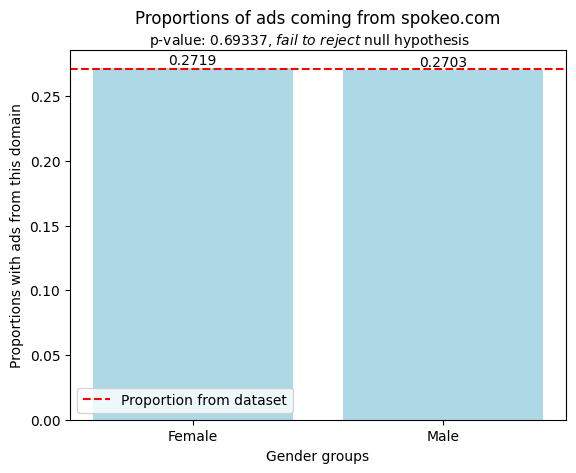

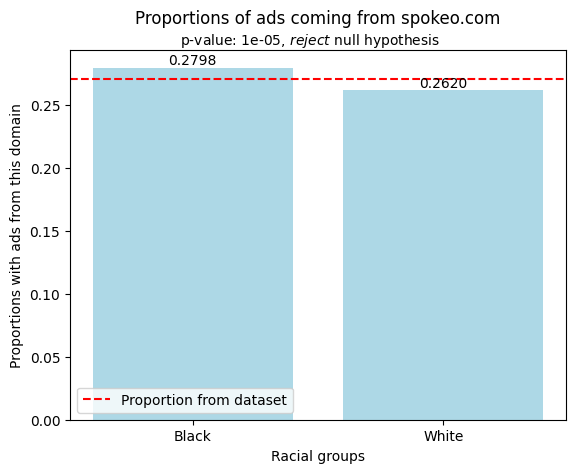

Ad Domain: publicrecords.info
9695 ads from this domain


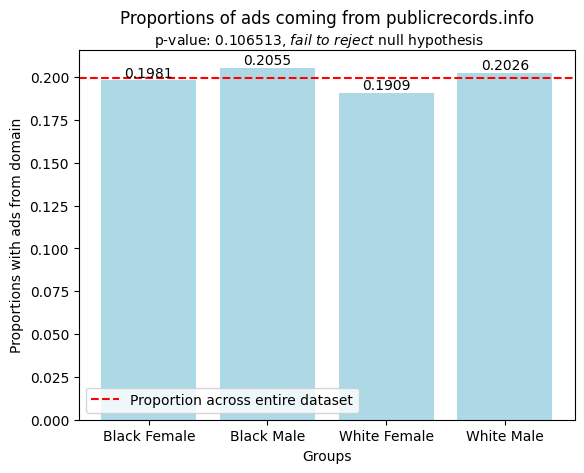

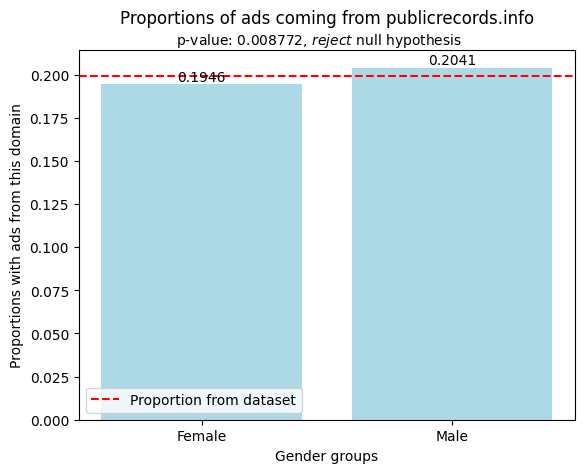

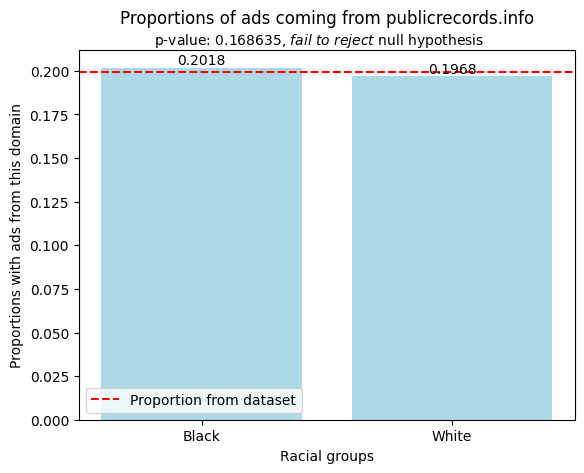

Ad Domain: police.us
7908 ads from this domain


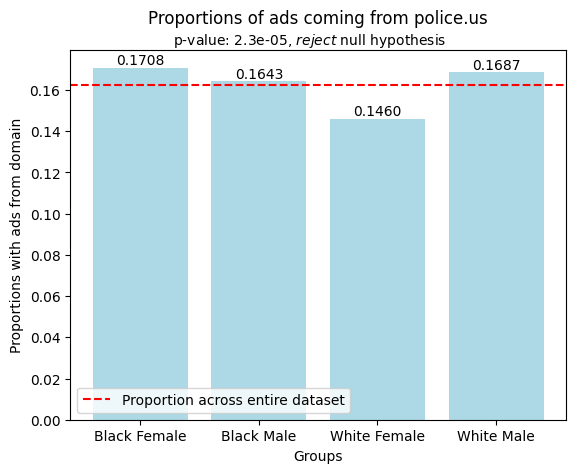

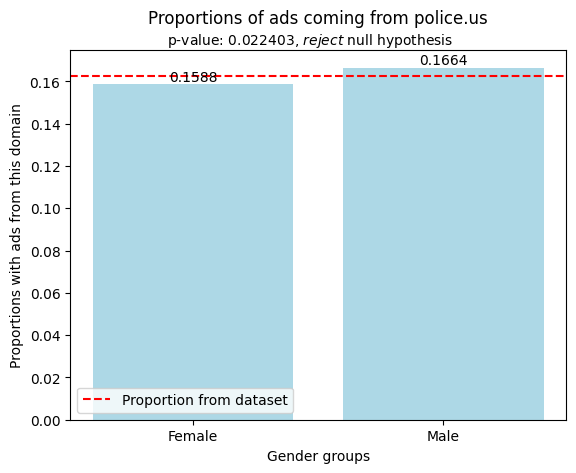

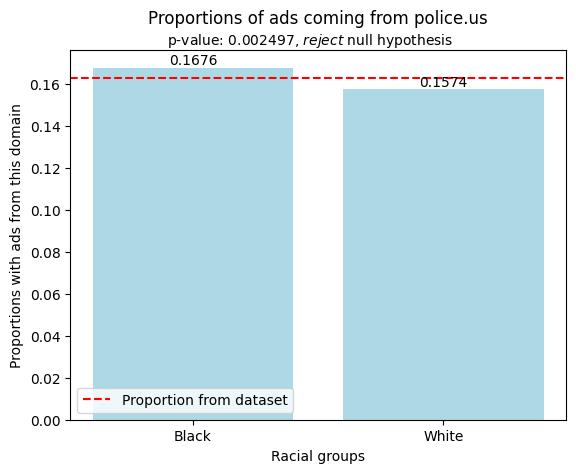

In [230]:
#  same hypothesis tests for the top 3 ad domains represented in the dataset.

#  A rejection of the null hypothesis means that this ad domain is over/under representing a gender, racial,
#  or combined gender + racial group based on what was seen in the original dataset.

#  For example, if we reject the null hypothesis for the domain spokeo.com and the racial grouping, this means
#  spokeo.com has a statistically significantly higher proportion of ads for one racial group (black or white) 
#  than the proportion that was seen in the original dataset.

#  A fail to reject result means that no significant difference was detected between the distribution of ads that
#  just appeared from this domain and the distribution that appeared in the original dataset.



for i in df['Ad Domain'].value_counts().index[:3]:
    print(f"\033[1mAd Domain: {i}\033[0m")
    
    #prep for both two-prop z tests
    df_filt = df[df['Ad Domain'] == i]
    print(f"{len(df_filt)} ads from this domain")
    racial_obs = [df.groupby('Race')['Criminal Ad'].count()['Black'], df.groupby('Race')['Criminal Ad'].count()['White']]
    racial_successes = [df_filt.groupby('Race')['Criminal Ad'].count()['Black'], df_filt.groupby('Race')['Criminal Ad'].count()['White']]
    gender_obs = [df.groupby('Sex')['Criminal Ad'].count()['Female'], df.groupby('Sex')['Criminal Ad'].count()['Male']]
    gender_successes = [df_filt.groupby('Sex')['Criminal Ad'].count()['Female'], df_filt.groupby('Sex')['Criminal Ad'].count()['Male']]
    
    #prep for chi-square test
    breakdown_regular = df.groupby('Group')['Criminal Ad'].count()
    breakdown_domain = df_filt.groupby('Group')['Criminal Ad'].count()
    cont_table = [[breakdown_domain['bf'], breakdown_regular['bf']], 
              [breakdown_domain['bm'], breakdown_regular['bm']], 
              [breakdown_domain['wf'], breakdown_regular['wf']], 
              [breakdown_domain['wm'], breakdown_regular['wm']]]
    
    #chi-square test
    chi2, p, dof, expected = stats.chi2_contingency(cont_table)
    
    #make plot to show race + gender group breakdowns
    proportions = [(breakdown_domain['bf'] / breakdown_regular['bf']), (breakdown_domain['bm'] / breakdown_regular['bm']), (breakdown_domain['wf'] / breakdown_regular['wf']), (breakdown_domain['wm']/breakdown_regular['wm'])]  
    group_labels = ['Black Female', 'Black Male', 'White Female', 'White Male']
    overall_prop = len(df_filt) / len(df)
    plt.bar(group_labels, proportions, color='lightblue')
    plt.axhline(y=overall_prop, color='red', linestyle='--', label='Proportion across entire dataset')
    for j in range(len(group_labels)):
        plt.text(j, proportions[j], f'{proportions[j]:.4f}', ha='center', va='bottom')
    plt.xlabel('Groups')
    plt.ylabel('Proportions with ads from domain')
    plt.title(f'Proportions of ads coming from {i}', y=1.05)
    if p < 0.05:
        plt.suptitle(f'p-value: {round(p, 6)}, $reject$ null hypothesis', y=0.92, fontsize=10)
    else:
        plt.suptitle(f'p-value: {round(p, 6)}, $fail$ $to$ $reject$ null hypothesis', y=0.92, fontsize=10)
    plt.legend(loc='lower left')
    plt.show()
        
    #both two-prop z tests for difference between just gender and just racial groups
    
    gender_p = two_prop_z_test(gender_successes, gender_obs)
    
    gender_props = [(gender_successes[0] / gender_obs[0]), (gender_successes[1] / gender_obs[1])]
    gender_groups = ['Female', 'Male']
    plt.bar(gender_groups, gender_props, color='lightblue')
    plt.axhline(y=overall_prop, color='red', linestyle='--', label='Proportion from dataset')
    for j in range(len(gender_groups)):
        plt.text(j, gender_props[j], f'{gender_props[j]:.4f}', ha='center', va='bottom')
    plt.xlabel('Gender groups')
    plt.ylabel('Proportions with ads from this domain')
    plt.title(f'Proportions of ads coming from {i}', y=1.05)
    if gender_p < 0.05:
        plt.suptitle(f'p-value: {round(gender_p, 6)}, $reject$ null hypothesis', y=0.92, fontsize=10)
    else:
        plt.suptitle(f'p-value: {round(gender_p, 6)}, $fail$ $to$ $reject$ null hypothesis', y=0.92, fontsize=10)

    plt.legend(loc='lower left')
    plt.show()
            
    racial_p = two_prop_z_test(racial_successes, racial_obs)
    
    racial_props = [(racial_successes[0] / racial_obs[0]), (racial_successes[1] / racial_obs[1])]
    racial_groups = ['Black', 'White']
    
    plt.bar(racial_groups, racial_props, color='lightblue')
    plt.axhline(y=overall_prop, color='red', linestyle='--', label='Proportion from dataset')
    for j in range(len(racial_groups)):
        plt.text(j, racial_props[j], f'{racial_props[j]:.4f}', ha='center', va='bottom')
    plt.xlabel('Racial groups')
    plt.ylabel('Proportions with ads from this domain')
    plt.title(f'Proportions of ads coming from {i}', y=1.05)
    if racial_p < 0.05:
        plt.suptitle(f'p-value: {round(racial_p, 6)}, $reject$ null hypothesis', y=0.92, fontsize=10)
    else:
        plt.suptitle(f'p-value: {round(racial_p, 6)}, $fail$ $to$ $reject$ null hypothesis', y=0.92, fontsize=10)
    plt.legend(loc='lower left')
    plt.show()